<a href="https://colab.research.google.com/github/barrosm/DeepLearningExamples/blob/master/LSTM_AirPassengers_20200509.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Recurrent Neural Network - LSTM


## SALVAR CONTEÚDO NO DRIVE PESSOAL!!!!! BAIXAR ESTA PASTA E FAZER UPLOAD PARA O SEU DRIVE

## Mount do drive pessoal

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import os
workdir_path = '/content/drive/My Drive/BIMaster_2019/Redes_Neurais/Airline/'
#/Redes_Neurais/' #/Airline'  # Inserir o local da pasta onde estão os arquivos de entrada (treino e teste)
os.chdir(workdir_path)

In [4]:
#Verificar se a pasta mapeada contem os arquivos abaixo
!ls

RedesRecorrentesAirPassengers.ipynb  test.csv  train.csv


## Parte 1 - Preprocessamento de Dados

### Importar as bibliotecas

In [5]:
%tensorflow_version 1.x
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

TensorFlow 1.x selected.


### Importar a base de dados

In [0]:
dataset_train = pd.read_csv('train.csv')
training_set = dataset_train.iloc[:, 1:2].values #só coluna da série em si

### gráfico da série temporal

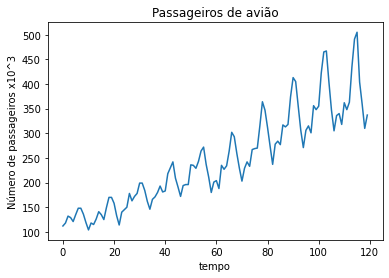

In [7]:
plt.plot(training_set)
plt.xlabel("tempo")
plt.ylabel("Número de passageiros x10^3")
plt.title("Passageiros de avião")
plt.show()

### Normalização

In [0]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

In [16]:
training_set_scaled[0:5]

array([[0.01995012],
       [0.03491272],
       [0.06982544],
       [0.06234414],
       [0.04239401]])

### Criar a estrutura de dados com janela 10 e output 1

## Mas pode ser interessante usar window = 12, por causa da sazonalidade, ou , por exemplo usar t-1, t-2, t-3, t-12, t-24

In [0]:
window = 10
trainSize = len(training_set_scaled)
X_train = []
y_train = []
for i in range(window, trainSize):    # vai de 10 até 120. Tem que começar no tamanho da janela, ppor que antes disso não se consegue prever nada
    X_train.append(training_set_scaled[i-window:i, 0])  # aqui só existe a coluna 0, pega os 10 valores anteriores a i, EXCLUSIVE i
    y_train.append(training_set_scaled[i, 0])  # é o que está sendo previsto, a observação no instante i
X_train, y_train = np.array(X_train), np.array(y_train)

### Reshaping

A LSTM espera que se entre com 3 dimensões como input. A 3a dimensão que foi colocada aí, com o reshape não serve para nada, só para adicionar uma dimensão

In [33]:
X_train.shape

(110, 10)

In [0]:
# O reshape 3D é feito aqui
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [35]:
X_train.shape

(110, 10, 1)

In [23]:
X_train[0:3]

array([[[0.01995012],
        [0.03491272],
        [0.06982544],
        [0.06234414],
        [0.04239401],
        [0.07730673],
        [0.10972569],
        [0.10972569],
        [0.0798005 ],
        [0.03740648]],

       [[0.03491272],
        [0.06982544],
        [0.06234414],
        [0.04239401],
        [0.07730673],
        [0.10972569],
        [0.10972569],
        [0.0798005 ],
        [0.03740648],
        [0.        ]],

       [[0.06982544],
        [0.06234414],
        [0.04239401],
        [0.07730673],
        [0.10972569],
        [0.10972569],
        [0.0798005 ],
        [0.03740648],
        [0.        ],
        [0.03491272]]])

## Parte 2 - Construção da RNN

### Bibliotecas necessárias

In [0]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

### Construção da Rede completa

In [39]:
# Inicializar a RNN
regressor = Sequential()  # criei uma rede que é uma sequencia de camadas que não tem nada

# Aqui foram colocadas 3 camadas LSTM, mas talvez só uma seja mais que suficiente

# Adicionar a primeira camada LSTM e Dropout 
regressor.add(LSTM(units = 100, return_sequences = True, input_shape = (X_train.shape[1], 1)))
# input_shape é 10 x 1, cada uma das 110 linhas tem este shape
# poderia ter definido, para ficar ainda mais geral: input_shape = 
# = (X_train.shape[1], X_train.shape[2])
regressor.add(Dropout(0.2))  # 20% dos neuronios vão ser aleatoriamente desconsiderados

# NAS PROXIMAS CAMADAS ESTOU REDUZINDO O NUMERO DE NEURONIOS, A PROXIMA TEM 80 NEURONIOS AO
# INVES DE 100

# O ULTIMO MODULOA DE LSTM VAI SER CONECTADO A UMA CAMADA DENSA

 
# Adicionar a segunda camada LSTM e Dropout
regressor.add(LSTM(units = 80, return_sequences = True))
regressor.add(Dropout(0.2))
 
# Adicionar a terceira camada LSTM e Dropout
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))
 
#===============================================================================
# A CAMADA DE SAÍDA É DENSA
# camada de saída
# POR PADRÃO, A FUNÇÃO DE ATIVAÇÃO, SE NÃO ESPECIFICADA, É LINEAR, a(x) = x
# ISSO FAZ SENTIDO AQUI POIS NÃO LIMITA O VALOR DA SAÍDA
# SE USÁSSEMOS UMA SIGMOIDE, POR EXEMPLO, ESTARÍAMOS RESTRITOS A (0,1)
# E COMO OS DADOS DE ENTRADA ESTÃO NORMALIZADOS ENTRE  0 E 1, ISSO FARIA 
# COM QUE MEU OUTPUT FICASSE RESTRITO AO RANGE DE VALORES DO CONJUNTO DE TREINAMENTO
#===============================================================================
regressor.add(Dense(units = 1))
 
# Após definir a camada de saída, compilar a rede 
# Compilar a rede
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Visualizar a rede
regressor.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 10, 100)           40800     
_________________________________________________________________
dropout_4 (Dropout)          (None, 10, 100)           0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 10, 80)            57920     
_________________________________________________________________
dropout_5 (Dropout)          (None, 10, 80)            0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 50)                26200     
_________________________________________________________________
dropout_6 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                

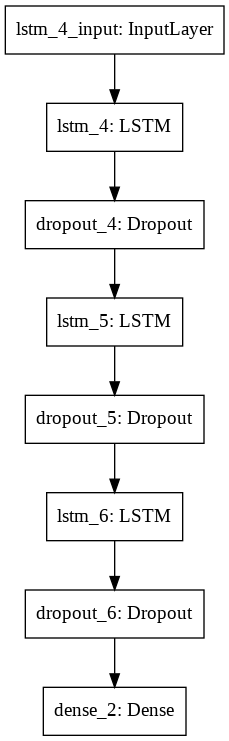

In [71]:
from keras import utils
utils.plot_model(regressor)

### Treinamento

In [40]:
history = regressor.fit(X_train, y_train, epochs = 250, batch_size = 32) # a cada 32 registros (dos 110) vai atualizar os pesos?


Epoch 1/250
110/110 [==============================] - 3s 23ms/step - loss: 0.1501
Epoch 2/250
110/110 [==============================] - 0s 1ms/step - loss: 0.0451
Epoch 3/250
110/110 [==============================] - 0s 1ms/step - loss: 0.0386
Epoch 4/250
110/110 [==============================] - 0s 1ms/step - loss: 0.0181
Epoch 5/250
110/110 [==============================] - 0s 1ms/step - loss: 0.0290
Epoch 6/250
110/110 [==============================] - 0s 1ms/step - loss: 0.0215
Epoch 7/250
110/110 [==============================] - 0s 1ms/step - loss: 0.0203
Epoch 8/250
110/110 [==============================] - 0s 1ms/step - loss: 0.0212
Epoch 9/250
110/110 [==============================] - 0s 1ms/step - loss: 0.0166
Epoch 10/250
110/110 [==============================] - 0s 1ms/step - loss: 0.0185
Epoch 11/250
110/110 [==============================] - 0s 1ms/step - loss: 0.0198
Epoch 12/250
110/110 [==============================] - 0s 1ms/step - loss: 0.0198
Epoch 13/25

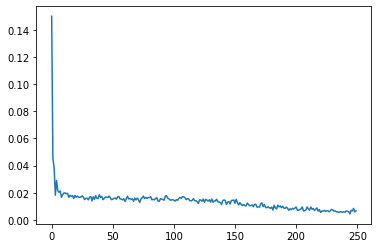

In [42]:
plt.plot(history.history['loss'], label = 'train');

In [0]:
from keras.utils.vis_utils import plot_model

## Parte 3 - Fazer as previsões e analisar os resultados

### Base de teste

In [0]:
dataset_test = pd.read_csv('test.csv')
test_airline = dataset_test.iloc[:, 1:2].values

### Construir a estrutura para teste

In [60]:
# preciso pegar parte da base de treino
# por ex, para preever os primeiros valores da base de testes preciso de alguns valores que estãoo na base de treino

# O tamanho da base de teste é 24
dataset_total = pd.concat((dataset_train.iloc[:,1], dataset_test.iloc[:,1]), axis = 0)
testLength = len(dataset_test)
# pegar todos os valores da base de teste e os ultimos da base de treino
inputs = dataset_total[len(dataset_total) - testLength - window:].values
inputs = inputs.reshape(inputs.shape[0],1)

inputs.shape


(34, 1)

In [0]:
###Normalização

In [0]:
inputs = sc.transform(inputs)
X_test = []
for i in range(window, inputs.shape[0]): 
    X_test.append(inputs[i-window:i, 0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [63]:
X_test.shape

(24, 10, 1)

### Fazer as previsões

In [64]:
predicted_airline = regressor.predict(X_test)
predicted_airline[0:5]


array([[0.56057847],
       [0.61613464],
       [0.61967343],
       [0.76631796],
       [0.75939316]], dtype=float32)

In [65]:
# Agora desnormalize as previsoes
predicted_airline = sc.inverse_transform(predicted_airline)
predicted_airline[0:5]

array([[328.79196],
       [351.06998],
       [352.48904],
       [411.2935 ],
       [408.51666]], dtype=float32)

### Visualizar os resultados de treino e teste

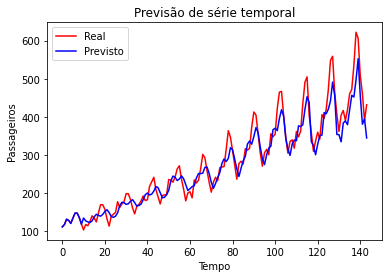

In [66]:
allTargetData = np.vstack((training_set, test_airline)) # concatena bases dde treino e teste
training_predicted_airline = regressor.predict(X_train) #predito para o treino
training_predicted_airline = sc.inverse_transform(training_predicted_airline) # desnormaliza previsto para o treino
allForecastedData = np.vstack((training_set[0:window], training_predicted_airline, predicted_airline)) #concatena previsoes
plt.plot(allTargetData, color = 'red', label = 'Real')
plt.plot(allForecastedData, color = 'blue', label = 'Previsto')
plt.title('Previsão de série temporal')
plt.xlabel('Tempo')
plt.ylabel('Passageiros')
plt.legend()
plt.savefig('predictions_training_test.png')
plt.show()

## Parte 4 - Métricas de avaliação

In [67]:
import math
from sklearn.metrics import mean_squared_error
rmse = math.sqrt(mean_squared_error(test_airline, predicted_airline))
print('RMSE: ', rmse)

RMSE:  56.80431265923948


In [68]:
mse = mean_squared_error(test_airline, predicted_airline)
print('MSE: ',mse)

MSE:  3226.729936688634


In [69]:
mape = np.mean(np.abs((test_airline - predicted_airline) / test_airline)) * 100
print('MAPE: ',mape)

MAPE:  9.634304454508108
